# Проект: классификация

In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
# plt.style.use('ggplot')

# доступные стили отображения графика в matplotlib
# plt.style.available

# библиотека иерархической кластеризации (для построения дендрограммы) 
# from scipy.cluster import hierarchy

# библиотека для построения выпуклой оболочки множества точек 
# from scipy import spatial

# from ydata_profiling import ProfileReport         # отключено пока не "починят"
# import sweetviz as sv
# import dtale
# import statistics as stcs
# import statsmodels.stats.proportion as stsmdls

# библиотека для расчетов корреляций
# from scipy import stats
from sklearn import metrics

# библиотека для нормализации, стандартизации
from sklearn import preprocessing

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели деревьев решения
from sklearn import tree

# библиотека модели ансамблей
from sklearn import ensemble

# библиотека модели кластеризации
# from sklearn import cluster

# библиотека модели эллиптической кластеризации
# from sklearn import mixture

# библиотека модели метода главных компонент PCA
# from sklearn import decomposition

# библиотека модели TSNE
# from sklearn import manifold

# библиотека clustergram-кластеризации
# from clustergram import Clustergram

# библиотека для разделения датасета
from sklearn import model_selection

# библиотека для исключения признаков RFE
from sklearn import feature_selection

# библиотека для кодирования признаков
import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
# import json
from pprint import pprint

# веб-скрэпинг сайтов
# import requests
# from bs4 import BeautifulSoup

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# загрузка файлов
# import wget
# import kaggle

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# библиотека для передачи функции обратного вызова
# from functools import partial

# библиотека поиска гиперпараметров hyperopt
# import hyperopt
# from hyperopt import hp, fmin, tpe, Trials

# библиотека поиска гиперпараметров optuna
import optuna
from optuna import Trial, study, samplers

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_info_rows', 100)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_rows', 50)

In [2]:
# КОНСТАНТЫ
# фиксация генерации воспроизведения
RANDOM_SEED = 42

# число фолдов кросс-валидации
CV_FOLDS = 5

# число ядер для расчётов моделей
CPU = -1

In [3]:
# создаём объект класса как estimator
def get_estimator_clf(
    model_type:linear_model.LogisticRegression | tree.DecisionTreeClassifier | \
    ensemble.RandomForestClassifier | ensemble.GradientBoostingClassifier,
    
    **params:dict | None
    
    ) -> linear_model.LogisticRegression | tree.DecisionTreeClassifier | \
    ensemble.RandomForestClassifier | ensemble.GradientBoostingClassifier:
    """ Функция генерации объекта класса: логистическая регрессия, "дерево решений", "случайного леса" или градиентного бустинга.
        Принимает на вход словарь с параметрами. Если словарь пустой - создаётся модель с параметрами по умолчанию.

    Returns:
        estimator_ (
            linear_model.LogisticRegression
            
            tree.DecisionTreeClassifier,
            
            ensemble.RandomForestClassifier, 
            
            ensemble.GradientBoostingClassifier):   объект класса логистическая регрессия (linear_model.LogisticRegression)
                                                    
                                                    объект класса "дерево решений" (DecisionTreeClassifier)
                                                    
                                                    объект класса "случайный лес" (RandomForestClassifier)
                                                    
                                                    объект класса градиентный бустинг (GradientBoostingClassifier)
    """
    # словарь парараметров модель
    params_estimator_ = {
        **params,                           # внешние параметры
        'class_weight':'balanced',          # веса классов
        'random_state':RANDOM_SEED,
        'n_jobs':CPU
    }
    match model_type:
        case 'log_reg':
            estimator_ = linear_model.LogisticRegression(**params_estimator_)
        
        case 'dt_clf':
            params_estimator_.pop('n_jobs')
            estimator_ = tree.DecisionTreeClassifier(**params_estimator_)
        
        case 'rf_clf':
            estimator_ = ensemble.RandomForestClassifier(**params_estimator_)
        
        case 'gb_clf':
            params_estimator_.pop('n_jobs')
            params_estimator_.pop('class_weight')
            estimator_ = ensemble.GradientBoostingClassifier(**params_estimator_)
    return estimator_

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
df = pd.read_csv('./data/bank_fin.csv', sep = ';')

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   age        int64 
 1   job        object
 2   marital    object
 3   education  object
 4   default    object
 5   balance    object
 6   housing    object
 7   loan       object
 8   contact    object
 9   day        int64 
 10  month      object
 11  duration   int64 
 12  campaign   int64 
 13  pdays      int64 
 14  previous   int64 
 15  poutcome   object
 16  deposit    object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
# Задание 2.1. В каком признаке пропущенных значений больше всего?
# пропуск дубликатов подходит именно такой, так как большинство пропусков - ноли.

print(f"Больше всего пропусков в признаке: '{df.isnull().sum().drop_duplicates(keep=False).idxmax()}'")
print(f"Пропусков: {df.isnull().sum().drop_duplicates(keep=False).iloc[0]}")

Больше всего пропусков в признаке: 'balance'
Пропусков: 25


### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

# Задание 2.2. Введите слово, которым закодированы пропуски (неизвестные значения).

print(f"Пропущенные значения обозначены словом: '{df['job'].value_counts().idxmin()}'")

Пропущенные значения обозначены словом: 'unknown'


### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

nan_mask = df['balance'].isnull() == False
df['balance'] = df[nan_mask]['balance'].apply(lambda x: x.replace(',', '.').replace(' ', ''))
df['balance'] = df[nan_mask]['balance'].apply(lambda x: x.split('.')[0].split('$')[0])
df['balance'] = df['balance'].astype('float')

df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [9]:
# Задание 2.3. Вычислите среднее значение по преобразованному в корректный вид признаку balance. 
# Ответ округлите до трёх знаков после точки-разделителя.

print(f"Средний баланс ДО заполнения пропусков: {df['balance'].mean().__round__(3)} $")

Средний баланс ДО заполнения пропусков: 1529.129 $


### Задание 4

In [10]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку

df['balance'].fillna(df['balance'].median(), inplace=True)

In [11]:
# Задание 2.4. Вычислите среднее значение по преобразованному в корректный вид признаку balance. 
# Ответ округлите до трёх знаков после точки-разделителя.

print(f"Средний баланс после заполнения пропусков: {df['balance'].mean().__round__(3)} $")

Средний баланс после заполнения пропусков: 1526.936 $


### Задание 5

In [12]:
# смотрим данные до преобразований
df['job'].value_counts()
df['education'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [13]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

df['job'].replace({'unknown':df['job'].mode()[0]}, inplace=True)
df['education'].replace({'unknown':df['education'].mode()[0]}, inplace=True)

In [14]:
# проверяем результат преобразований
df['job'].value_counts()
df['education'].value_counts()

job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [15]:
# Задание 2.5. После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой 
# и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
# Ответ округлите до трёх знаков после точки-разделителя.

mode_job = df['job'] == df['job'].mode()[0]
mode_edu = df['education'] == df['education'].mode()[0]

print(f"Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: " \
    f"{df[mode_job & mode_edu]['balance'].mean().__round__(3)} $")

Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: 1598.883 $


### Задание 6

In [16]:
def outliers_iqr_mod(
    data:pd.DataFrame, col:str, 
    left:float=1.5, right:float=1.5, 
    log_scale:bool=False, log_plus_1:bool=True
    ) -> float | pd.DataFrame:
    """ Функция принимает на вход DataFrame и признак, по которому ищутся выбросы по методу Тьюки

    Args:
        data (<class 'pandas.core.frame.DataFrame'>): Название DataFrame
        col (str): Название колонки в DataFrame
        left (float): Размах левой границы
        right (float): Размах правой границы
        log_scale (bool, optional): Триггер, применение логарифмирования к DataFrame из библиотеки numpy. 
                                    Defaults to False.
        log_plus_1 (bool, optional): Триггер, логарифмирование DataFrame с +1 или 0. 
                                    Defaults to True.

    Returns:
        <class 'pandas.core.frame.DataFrame'>: возвращает потенциальные выбросы, найденные с помощью метода Тьюки, 
                                                и очищенный от них датасет
    """
    if log_scale:                                                   # логарифмируем, если log_scale=True
        if log_plus_1:                                              # если триггер равен 1,
            x = np.log(data[col] + 1)                               # тогда логарифмируем DataFrame + 1
        else:
            x = np.log(data[col])                                   # иначе логарифмируем DataFrame
    else:
        x = data[col]                                               # иначе, просто задаем DataFrame
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),    # квартили 1-ый и 3-ий
    iqr = quartile_3 - quartile_1                                   # межквартильное расстояние
    lower_bound_ = quartile_1 - (iqr * left)                        # нижняя граница Тьюки
    upper_bound_ = quartile_3 + (iqr * right)                       # верхняя граница Тьюки
    outliers_ = data[(x < lower_bound_) | (x > upper_bound_)]       # потенциальные выбросы
    cleaned_ = data[(x >= lower_bound_) & (x <= upper_bound_)]      # очищенный от выбросов DataFrame
    return lower_bound_, upper_bound_, outliers_, cleaned_

lower_bound, upper_bound, outliers, df = outliers_iqr_mod(df, 'balance')

In [17]:
# удалите все выбросы для признака balance

print(f'Число выбросов: {outliers.shape[0]} записей')

Число выбросов: 1057 записей


In [18]:
# Задание 2.6. Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

print(f'Границы нижняя и верхняя: [{round(lower_bound)}; {round(upper_bound)}]')

Границы нижняя и верхняя: [-2241; 4063]


In [19]:
# Задание 2.7. Сколько объектов осталось после удаления всех выбросов?

print(f"Число записей после очистки выбросов в признаке 'balance': {df.shape[0]} записей")

Число записей после очистки выбросов в признаке 'balance': 10105 записей


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64


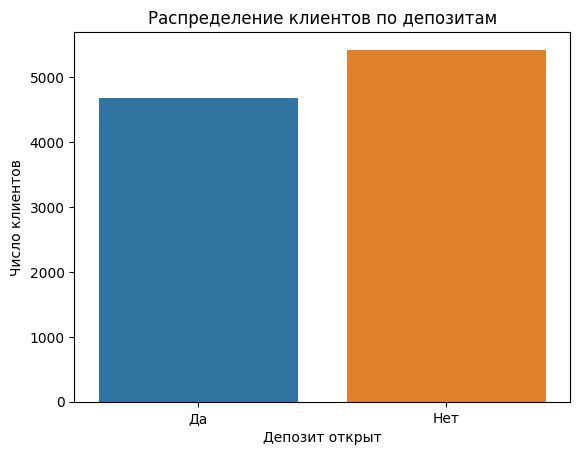

In [20]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

print(f"{df['deposit'].value_counts()}\n")
print(df['deposit'].value_counts(normalize=True))

ax = sns.countplot(x=df['deposit'])
ax.set(
    title='Распределение клиентов по депозитам',
    xlabel='Депозит открыт', 
    ylabel='Число клиентов',
    xticklabels=['Да', 'Нет']
);

In [21]:
# Задание 3.1. Сколько клиентов открыли депозит?

print(f"Число клиентов открывших депозит: {df[df['deposit']=='yes'].shape[0]} чел")

Число клиентов открывших депозит: 4681 чел


### Задания 2 и 3

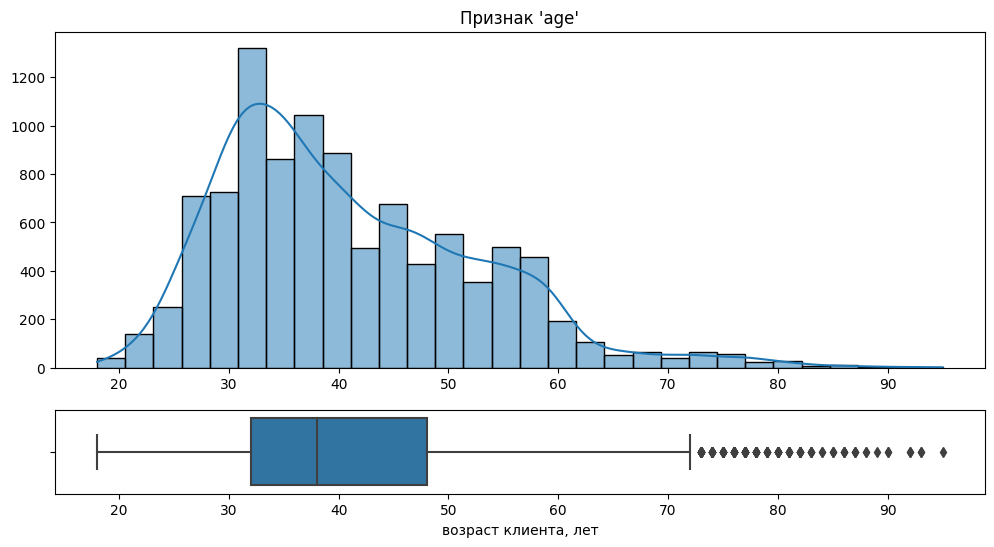

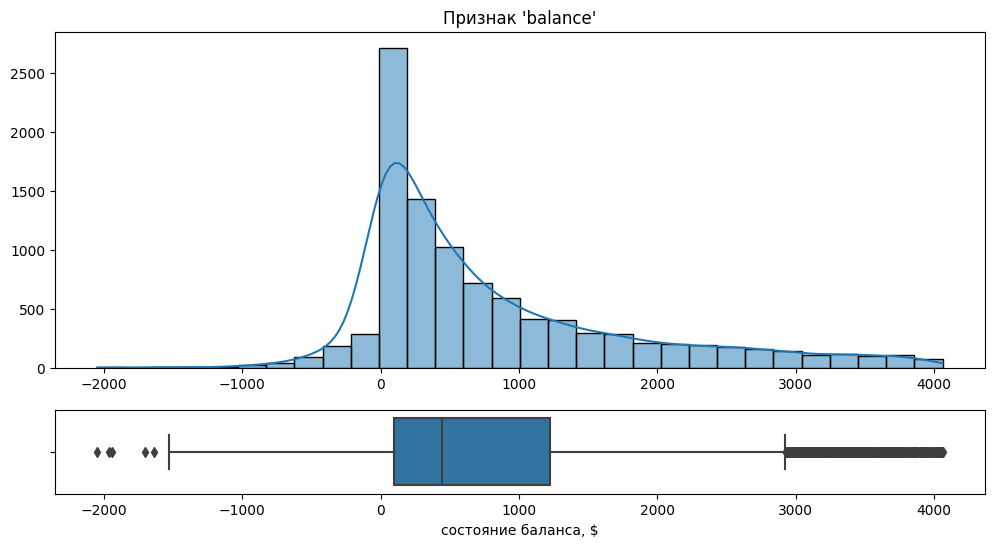

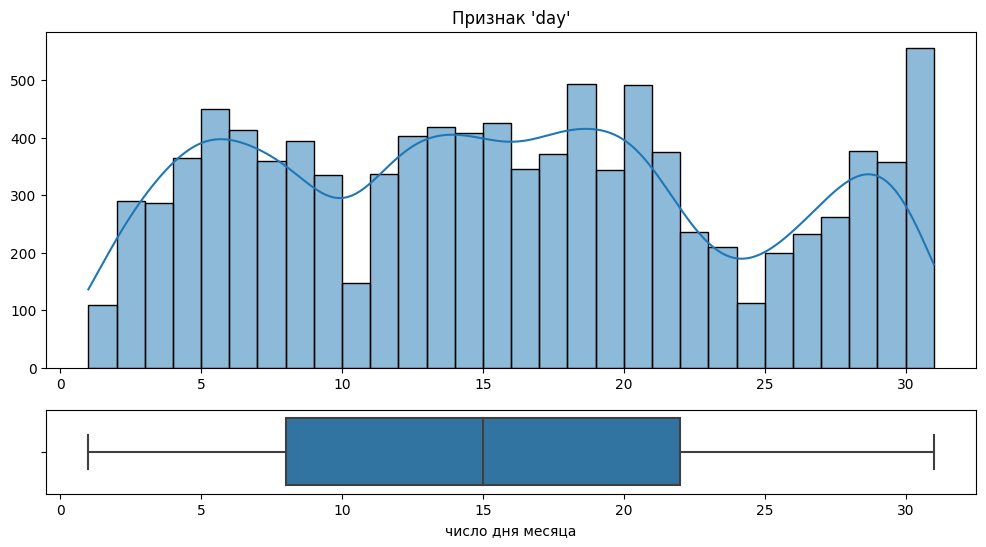

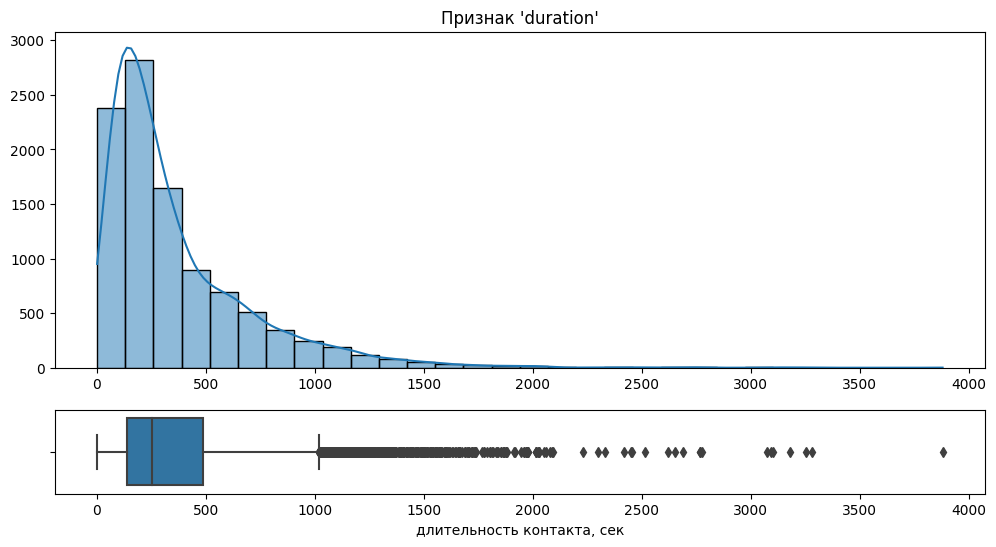

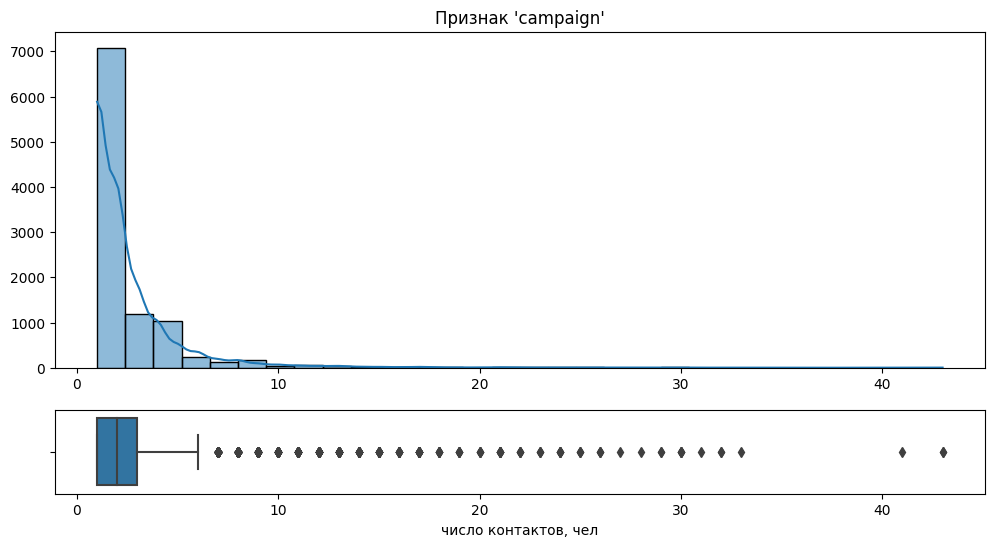

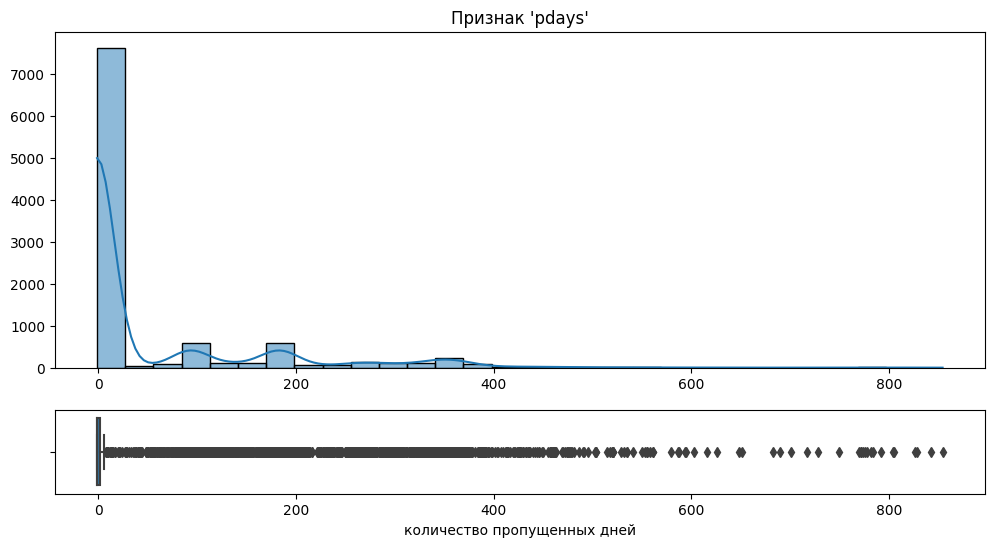

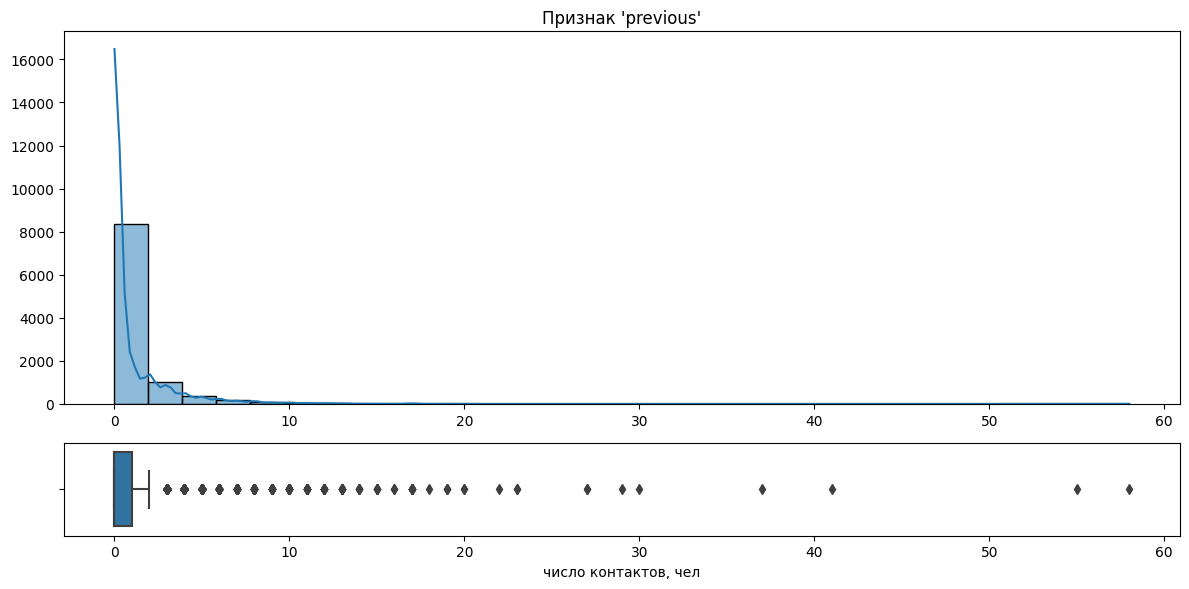

In [22]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

# формируем количественные признаки
num_features=[feature for feature in df.columns if (df[feature].dtypes !='O')]

# формируем метки оси абсцисс
xaxis_labels = ['возраст клиента, лет', 'состояние баланса, $', 'число дня месяца', 'длительность контакта, сек', 
                'число контактов, чел', 'количество пропущенных дней', 'число контактов, чел'
]

plot_number = 1
for i, col in enumerate(num_features):
    # задаем полотно для 2 графиков
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': (0.8, 0.2)})
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=ax_hist)
    sns.boxplot(data=df, x=col, ax=ax_box)
    
    # задаем подписи осей и заголовок гистограммы
    ax_hist.set(
        title='Признак ' + "'" + col + "'",
        ylabel='',
        xlabel=''
        )
    
    # задаем подписи осей "ящика с усами"
    ax_box.set(
        ylabel='',
        xlabel=xaxis_labels[i]
        )
    plot_number += 1
plt.tight_layout();                                     # выравнивание графиков
plt.show();

#### **Выводы по количественным переменным:**

1. Пик возраста ('*age*') клинетов приходится на 30-35 лет. После 60 лет кол-во клиентов резко уменьшается, скорее всего, сказывается возраст и нежелением попадать в "банковские ловушки и сети", либо наличием неоптимальных и сложных банковских продуктов, в которых разбираться возратной категории нелегко.

2. Основное количество баланса ('*balance*') приходится на ноль, стоит отметить наличие отрицательных балансов - банку стоит подумать над тем, чтоб убрать выбросы отрицательной стороны этой малой части клиентов. Также явно прослеживается, нежеление клиентов хранить большие суммы на балансе, тоже вопрос к размышлению, как рекомендация - пересмотр линейки предлагаемых банков продуктов и услуг. Распределение логнормальное.
3. День, в который был последний контакт ('*day*'). Распределение равномерное. Сложно судить, есть пара провалов, но, относительно, явно просматривается 3 "площадки", в начале месяца, в середине и поменьше - в конце месяца.
4. Продолжительность контакта ('*duration*'). Средняя продолжительность контакта - чуть более 4 мин. Распределение логнормальное. Возможно наличие выбросов - контакты продолжительностью более 15 мин, и по логике, в реальной жизни так и есть, либо консультация специалистом банка отклонилась от скрипта, читайте, "непрофессиональная" подача информации о продуктах банках, либо клиент такой попался - педантичный и скрупулёзный.
5. Количество контактов ('*campaign*'). Распределение логнормальное. Выбросы - число контактов более 15.
6. Количество дней с момента предыдущей кампании ('*pdays*'). Распределение логнормальное. Выбросы - свыше 400 дней. Но если смотреть на графики, то **я бы предположил, что всё, что свыше 50 дней уже является выбросами**.
7. Количество предыдущих контактов ('*previous*'). Распределение логнормальное. Выбросы аналогичны признаку '*campaign*' - более 15.

In [23]:
# Задание 3.2. Каков максимальный возраст клиента банка?

print(f"Максимальный возраст клиента банка: {df['age'].max()} лет")

Максимальный возраст клиента банка: 95 лет


In [24]:
# Задание 3.3. Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

print(f"Минимальная продолжительность разговора с клиентом банка: {df['duration'].min()} сек")

Минимальная продолжительность разговора с клиентом банка: 2 сек


### Задания 4 и 5

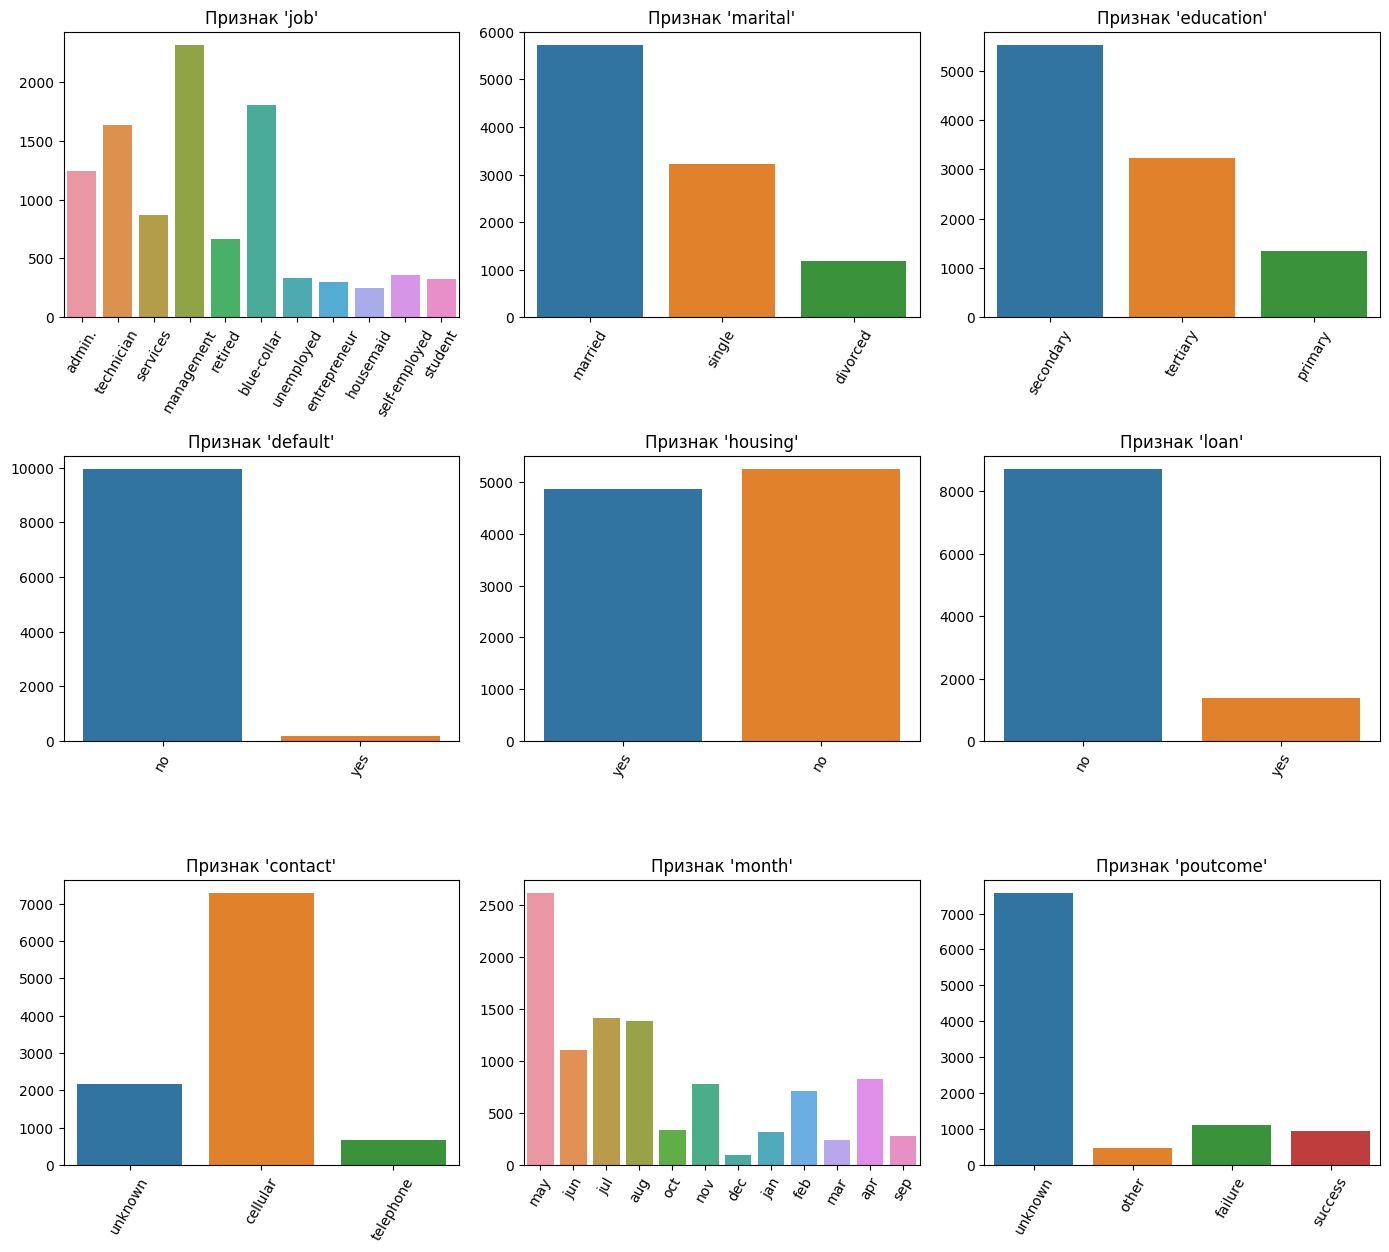

In [25]:
# рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

# формируем категориальные переменные
cat_cols = [feature for feature in df.columns if ((df[feature].dtypes=='O') & (feature not in ['deposit']))]

# размер общего полотна
plt.figure(figsize=(14, 50))
plot_number = 1
for col in cat_cols:
    # задаём параметры полотна
    ax_count = plt.subplot(12, 3, plot_number)
    sns.countplot(x=col, data=df)
    
    # задаем подписи осей и заголовок барплота
    ax_count.set(
        title='Признак ' + "'" + col + "'",
        ylabel='',
        xlabel=''
        )
    
    # поворот меток
    ax_count.xaxis.set_tick_params(rotation=60)

    # переход к следующей ячейке для построения графика
    plot_number += 1
plt.tight_layout();                                     # выравнивание графиков
plt.show();

#### **Выводы по количественным переменным:**

В целом, картина складывается достаточно оптимистичная, "портрет" основного клиента:

1. Занимает руководящую (управленческую) должность.

2. Женат.
3. Имеет высшее образование и / или второе высшее.
4. Не имеет просрочек и кредитов, кроме одного, ипотека, скорее всего, это единственный преобладающий вид банковского продукта, кроме прочих.
5. Доступен почти всегда по мобильному.
6. Данные о предыдущей кампании неизвестны, но большинство охотнее всего выходили на связь перед отпуском, месяц - май, преобладающий.

In [26]:
# Задание 3.4. Сколько было месяцев, в которых проводилась маркетинговая кампания?

print(f"Число месяцев маркетинговой кампании: {df['month'].nunique()}")
print(f"Месяцы маркетинговой кампании: {df['month'].unique()}")

Число месяцев маркетинговой кампании: 12
Месяцы маркетинговой кампании: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


In [27]:
# Задание 3.5. Сколько сфер занятости представлено среди клиентов банка?

print(f"Число сфер занятости представлено среди клиентов банка: {df['job'].nunique()}")
print(f"Сферы занятости среди клиентов банка: {df['job'].unique()}")

Число сфер занятости представлено среди клиентов банка: 11
Сферы занятости среди клиентов банка: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']


### Задание 6

In [28]:
# Задание 3.6
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


**Ответ**: success

### Задание 7

In [29]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# Задание 3.7. Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии 
# в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, 
# и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

df. \
    groupby('month')['deposit']. \
    value_counts(normalize=True). \
    unstack(). \
    sort_values('no', ascending=False)

# сохраняем в переменную для вывода
df_no_month = df. \
    groupby('month')['deposit']. \
    value_counts(normalize=True). \
    unstack(). \
    sort_values('no', ascending=False). \
    copy()

print(f"Месяц максимального числа отказов открытия депозита: '{df_no_month['no'].idxmax()}'")

deposit,no,yes
month,,
may,0.678640,0.321360
jan,0.608150,0.391850
jul,0.589563,0.410437
nov,0.584615,0.415385
aug,0.559567,0.440433
jun,0.548913,0.451087
feb,0.455571,0.544429
apr,0.381928,0.618072
oct,0.185075,0.814925


Месяц максимального числа отказов открытия депозита: 'may'


### Задание 8

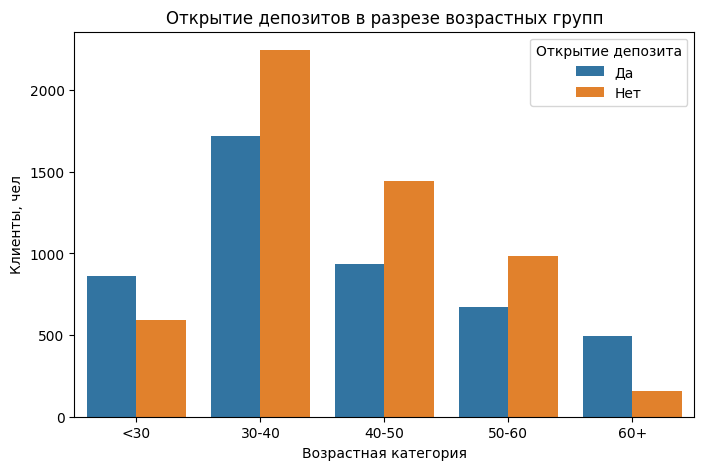

In [30]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

# Задание 3.8. Выберите из списка две возрастные группы, которые более склонны открывать депозит, 
# чем отказываться от открытия депозита в банке после рекламного предложения.
# значение 30 будет входить в диапазон [30, 40)

df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 30, 40, 50, 60, 200], 
    labels=['<30', '30-40', '40-50', '50-60', '60+'],
    include_lowest=True,                                # включать нижнюю (левую) границу
    right=False                                         # НЕ включать верхнюю (правую) границу
)

def plot_count(
        x_data_:str, 
        title_:str, xlabel_:str,
        figsize_:tuple=(8, 5), 
        df_:pd.DataFrame=df, 
        col_:pd.Series='deposit'
    ) -> None:
    """ Функция построения столбчатой диаграммы для отложения заданного столбца данных по оси x 
        в зависимости от открытия / неоткрытия депозита 

    Args:
        x_data_ (str): столбец данных для отложения по оси x
        
        title_ (str): заголовок графика
        
        xlabel_ (str): заголовок оси x

        figsize_ (tuple): размеры координатной сетки
        
        df_ (pd.DataFrame): исходный датафрейм
        
        col_ (pd.Series, optional): столбец принадлежности к категории открытия / неоткрытия депозита. 
                                    Defaults to 'deposit'.
    """

    # координатная сетка
    fig, axes = plt.subplots(1, 1, figsize=figsize_)
    
    # данные для построения графика
    ax_count = sns.countplot(
        data=df_, 
        x=x_data_, 
        hue=col_
    )

    # подписи осей и заголовок
    ax_count.set(
        title='Открытие депозитов в разрезе ' + title_,
        ylabel='Клиенты, чел',
        xlabel=xlabel_
    )

    # заголовок легенды и имена категорий
    ax_count.legend(
        ['Да', 'Нет'],
        title='Открытие депозита'
    )

plot_count('age_group', 'возрастных групп', 'Возрастная категория')

**Ответ:**<br>

* A **'<30'** (True)
* B '30-40'
* C '40-50'
* D '50-60'
* E **'60+'** (True)

### Задания 9 и 10

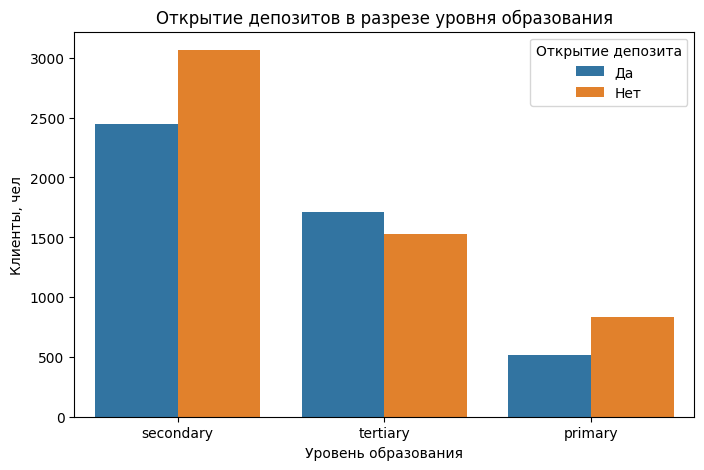

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

plot_count('education', 'уровня образования', 'Уровень образования')

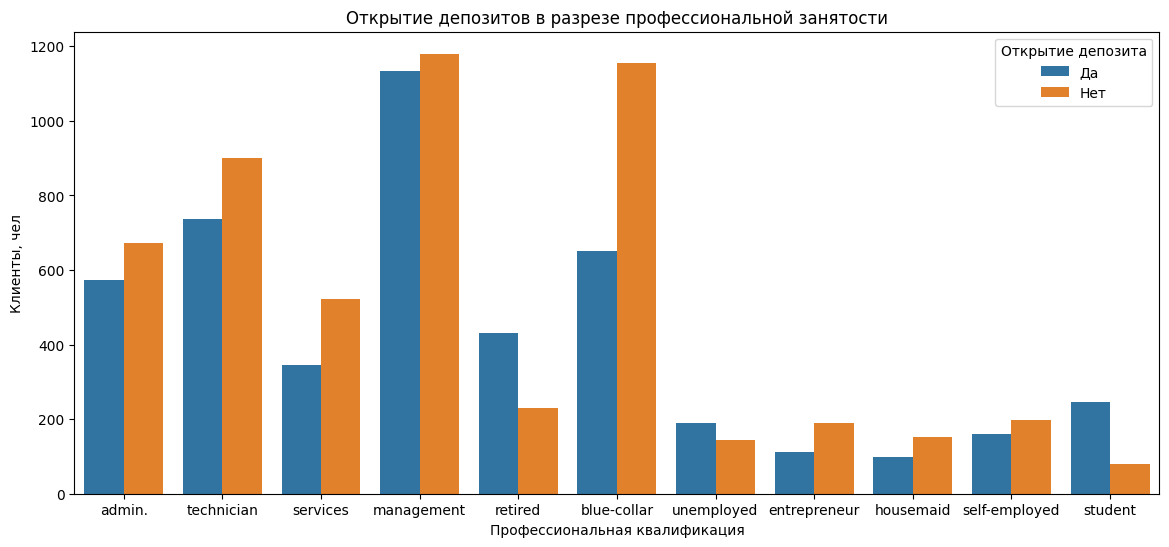

In [32]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

plot_count('job', 'профессиональной занятости', 'Профессиональная квалификация', (14, 6))

In [33]:
# Задание 3.9. В какой сфере занято наибольшее число клиентов банка?

df. \
    groupby('job')['job']. \
    value_counts(). \
    sort_values(ascending=False)

# сохраняем в переменную для вывода
df_job_mode = df. \
    groupby('job')['job']. \
    value_counts(). \
    sort_values(ascending=False). \
    copy()

print(f"Самая распространённая сфера занятости клиентов банка: '{df_job_mode.idxmax()}'")

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

Самая распространённая сфера занятости клиентов банка: 'management'


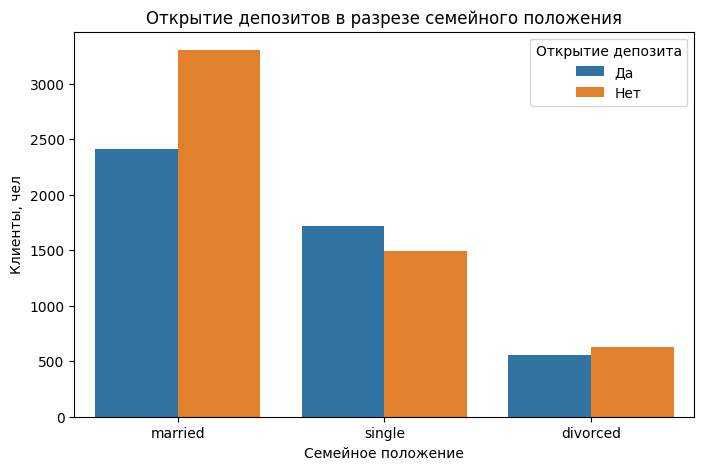

In [34]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

plot_count('marital', 'семейного положения', 'Семейное положение')

In [35]:
# Задание 3.10. При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

df. \
    groupby('marital')['deposit']. \
    value_counts(). \
    unstack(). \
    sort_values('yes', ascending=False)

# сохраняем в переменную для вывода
df_yes_marital = df. \
    groupby('marital')['deposit']. \
    value_counts(). \
    unstack(). \
    sort_values(by=['no','yes'], ascending=[False, True]). \
    copy()

deposit,no,yes
marital,,
married,3303,2412
single,1497,1716
divorced,624,553


**Ответ:** single ('*yes*' > '*no*')

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


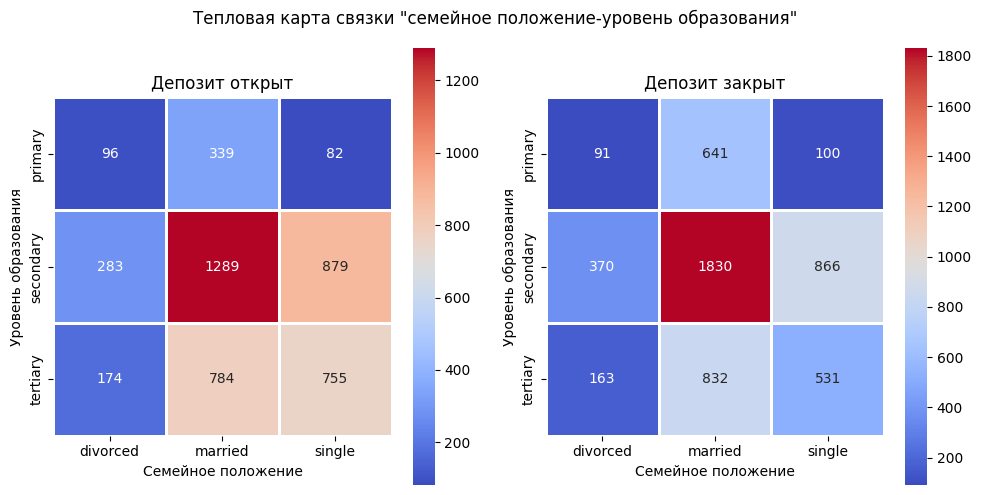

In [36]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

def plot_heatplot(yn_:str, subplot_title:str, ax_:plt.Axes, df_:pd.DataFrame=df) -> pd.DataFrame | plt.Axes:
    """ Функция формирования сводного датафрейма и вывода тепловой карты

    Args:
        yn_ (str): значение признака 'deposit' - 'yes' | 'no'
        subplot_title (str): подзаголовок графика
        ax_ (plt.Axes): подпространство осей, где строить график
        df_ (pd.DataFrame, optional): исходный датафрейм. Defaults to df.

    Returns:
        (pd.DataFrame, plt.Axes): сводный датафрейм, график-"тепловая карта"
    """
    # сводный датафрейм
    pivot = df_[df_['deposit'] == yn_] \
        .groupby(['education', 'marital']
        )['marital'] \
        .count() \
        .unstack()
    
    # тепловая карта
    ax_heat_ = sns.heatmap(
        pivot, 
        annot=True, 
        square=True,
        fmt='.0f', 
        linewidths=1, 
        cmap='coolwarm', 
        ax=ax_
    )

    # подписи осей и заголовок графика
    ax_heat_.set(
        title=subplot_title,
        xlabel='Семейное положение', 
        ylabel='Уровень образования'
    )
    return pivot, ax_heat_

# строим графики на одной координатной плоскости
fig, ax_heat = plt.subplots(1, 2, figsize=(10, 5))
pivot_yes, ax_heat[0] = plot_heatplot('yes', 'Депозит открыт', ax_heat[0])
pivot_no, ax_heat[1] = plot_heatplot('no', 'Депозит закрыт', ax_heat[1])

# общий для графиков заголовок
plt.suptitle('Тепловая карта связки "семейное положение-уровень образования"')

# выводим сводные таблицы
display(pivot_yes, pivot_no)

# выравниваем графики
plt.tight_layout();

## Часть 3: преобразование данных

### Задание 1

In [37]:
# преобразуйте уровни образования

# создание экземпляра класса LabelEncoder()
lbl_enc = preprocessing.LabelEncoder()

# кодирование признака 'education'
df['education'] = lbl_enc.fit_transform(df['education'])

# преобразование типа признака в 'int8'
df['education'] = df['education'].astype('int8')

In [38]:
# Задание 4.1. Найдите сумму получившихся значений для признака education.

print(f"Сумма значений признака 'education': {df['education'].sum()}")

Сумма значений признака 'education': 11995


### Задания 2 и 3

In [39]:
# кодирование признака 'age_group'
df['age_group'] = lbl_enc.fit_transform(df['age_group'])

# преобразование типа признака в 'int8'
df['age_group'] = df['age_group'].astype('int8')

In [40]:
def yes_no_enc(feature_value:str) -> int:
    """ Функция бинарного кодирования признака

    Args:
        feature_value (str): принимает на вход 'yes' | 'no'

    Returns:
        int: возвращение бинарного значения 1 | 0
    """
    # кодирование по правилу - {'yes':1, 'no':0}
    if (feature_value=='yes'):
        return 1
    return 0

# кодирование признака 'deposit'
df['deposit'] = df['deposit'].apply(yes_no_enc)

# преобразование типа признака в 'int8'
df['deposit'] = df['deposit'].astype('int8')

In [41]:
# Задание 4.2. Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. 
# Ответ округлите до трёх знаков после точки-разделителя.

print(f"Стандартное отклонение признака 'deposit': {df['deposit'].std():.3f}")

Стандартное отклонение признака 'deposit': 0.499


In [42]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# кодирование признака 'default'
df['default'] = df['default'].apply(yes_no_enc)

# кодирование признака 'housing'
df['housing'] = df['housing'].apply(yes_no_enc)

# кодирование признака 'loan'
df['loan'] = df['loan'].apply(yes_no_enc)

# преобразование типа признака в 'int8'
df['default'] = df['default'].astype('int8')
df['housing'] = df['housing'].astype('int8')
df['loan'] = df['loan'].astype('int8')

In [43]:
# Задание 4.3. Вычислите среднее арифметическое для каждой из получившихся переменных, 
# сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

print(f"Сумма средних арифметических признаков 'default', 'housing', 'loan': " \
    f"{(df['default'].mean() + df['housing'].mean() + df['loan'].mean()):.3f}")

Сумма средних арифметических признаков 'default', 'housing', 'loan': 0.635


### Задание 4

In [44]:
# создайте дамми-переменные

object_cols = list(df.select_dtypes(['object']).columns)
df_dummies = pd.get_dummies(df[object_cols])
df = pd.concat([df, df_dummies], axis=1)

In [45]:
# Задание 4.4. Сколько теперь всего признаков в датасете, не считая целевую переменную? 
# Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

# минус 1 - вычитаем целевой признак
print(f"Всего признаков, включая исходные 'object'-признаки (непреобразованные), кроме целевого: {df.shape[1] - 1}")

Всего признаков, включая исходные 'object'-признаки (непреобразованные), кроме целевого: 50


In [46]:
# удаляем исходные признаки типа 'object'
df.drop(columns=object_cols, inplace=True)

### Задания 5 и 6

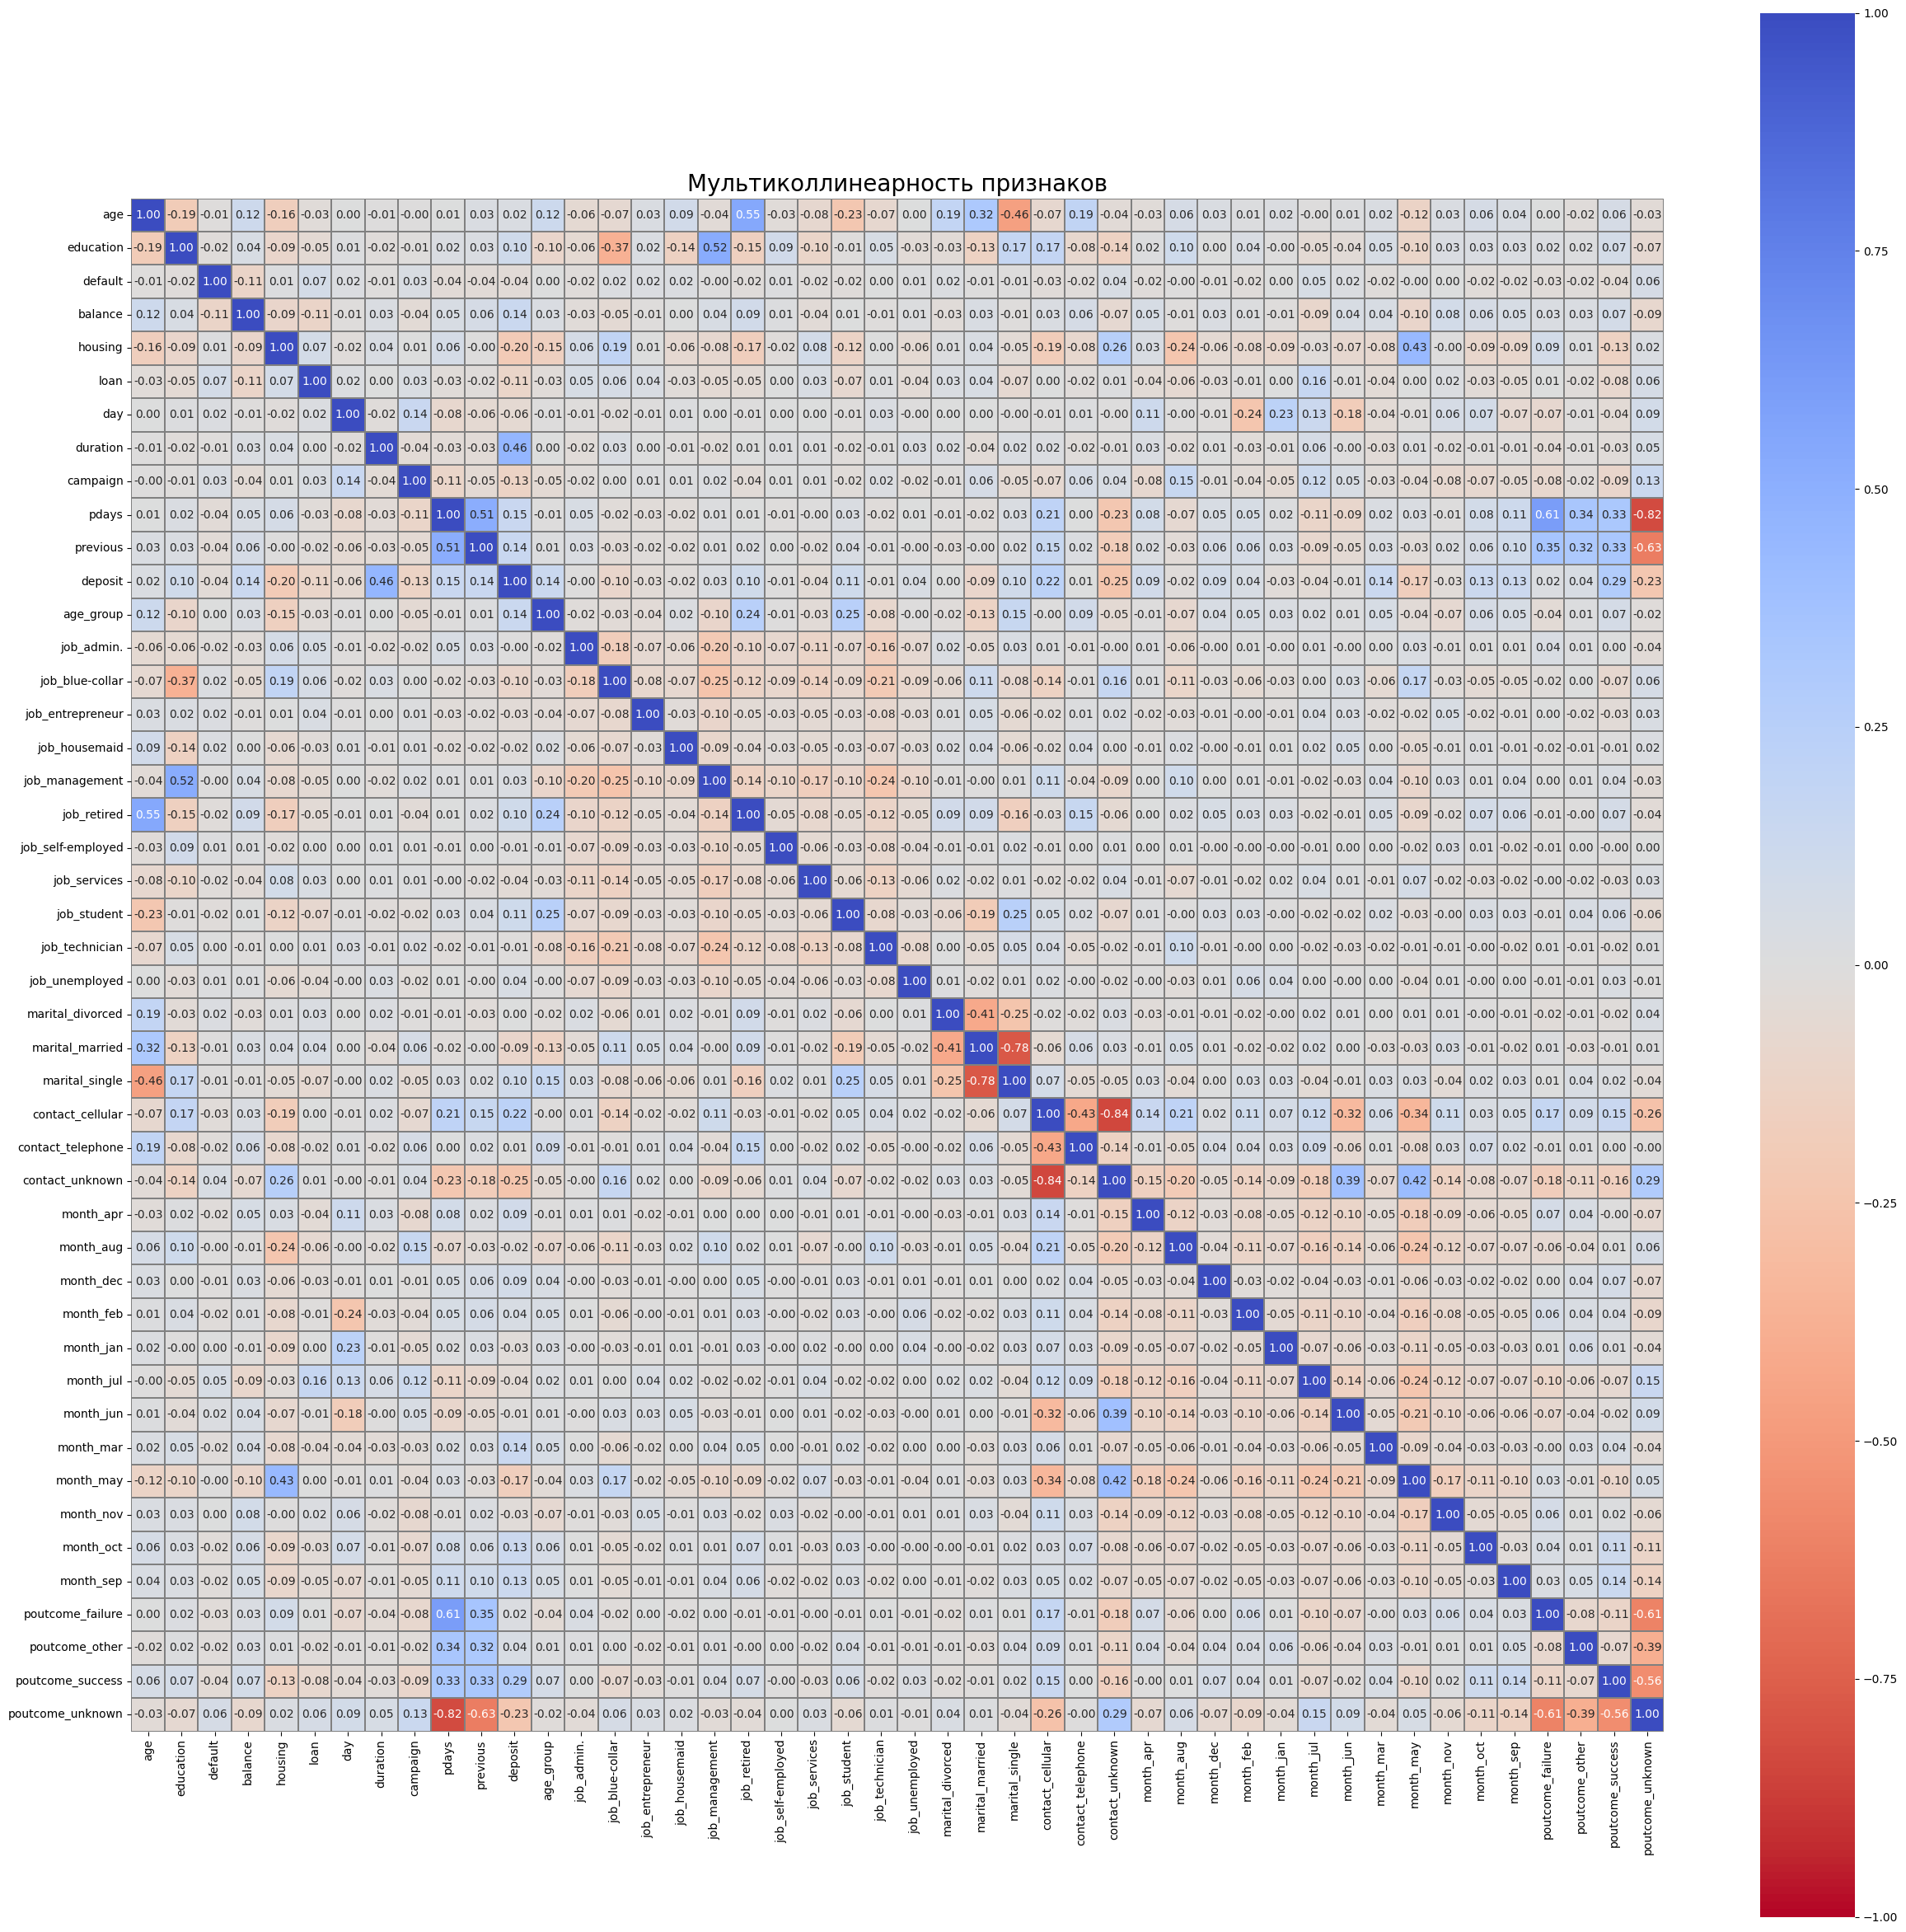

In [47]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# данные для построения графика
df_corr = df.corr()
plt.subplots(figsize=(30, 30))

# график - тепловая матрица с коэффициентами корреляции не менее 0.9
ax_heat_multicoll = sns.heatmap(
    # df_corr[df_corr.abs() >= 0.9],        # для вывода матрицы корреляции с коэффициентами не менее 0.9
    df.corr(),
    vmin=-1, 
    vmax=1, 
    linewidth=0.05, 
    linecolor='gray', 
    cmap='coolwarm_r',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

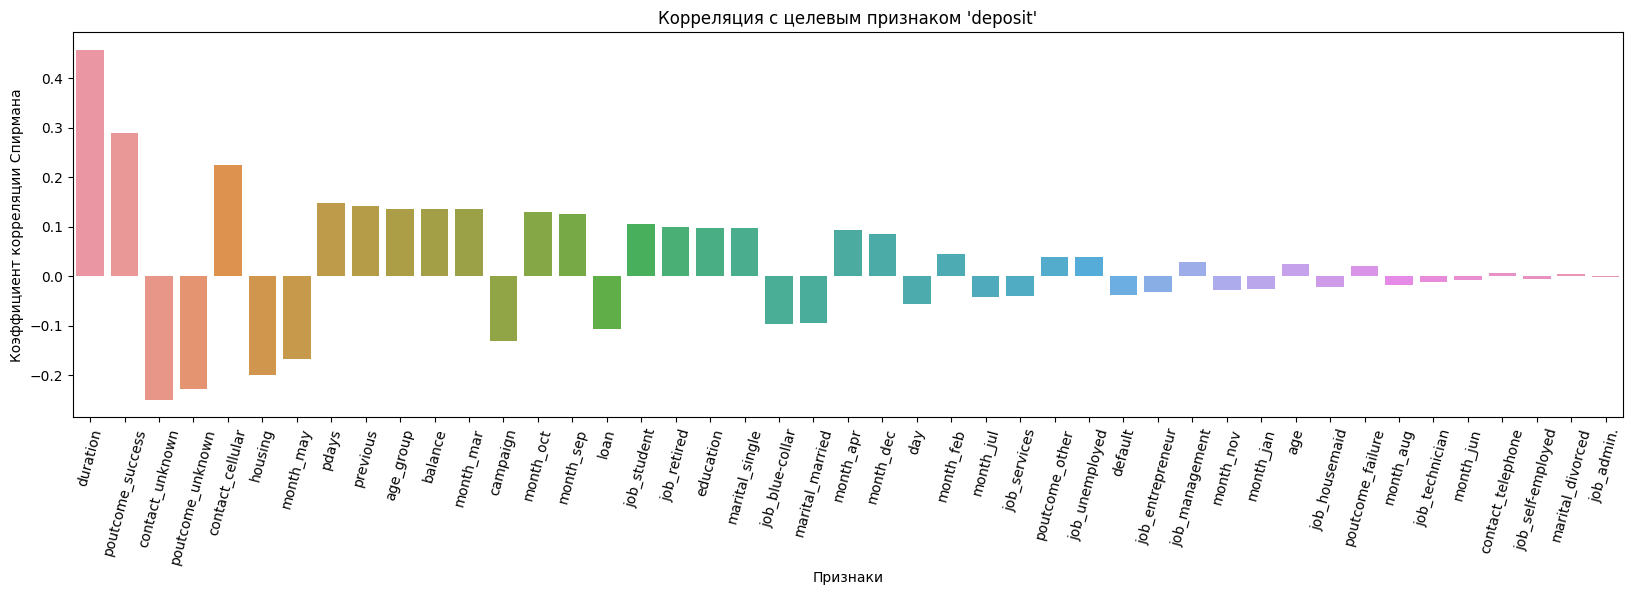

In [48]:
# график ранжированных значений корреляции признаков с целевым признаком
fig = plt.figure(figsize=(20, 5))

# датафрейм для графика
plot_df = df_corr.drop('deposit')      # убираем корреляцию 'deposit' с 'deposit' (самим собой)

# ранжирование признаков, забираем только индексы
feature_order = abs(plot_df['deposit']).sort_values(ascending=False).index

# столбчатый график
ax_bar = sns.barplot(
    plot_df.reset_index(),
    x='index', 
    y='deposit',
    order=feature_order
)

# поворот меток по оси абсцисс
ax_bar.xaxis.set_tick_params(rotation=75)

# заголовок и метки осей
ax_bar.set(title="Корреляция с целевым признаком 'deposit'", 
    xlabel='Признаки', 
    ylabel='Коэффициент корреляции Спирмана'
);

### Задания 7 и 8

In [49]:
# матрица наблюдений и целевой вектор
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# разбивка данных со стратификацией
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=RANDOM_SEED, 
    test_size=0.33
)

In [50]:
# Задание 4.7. Каким получился размер тестовой выборки?

print(f'Размерность тестовой выборки {X_test.shape}')

Размерность тестовой выборки (3335, 45)


In [51]:
# Задание 4.8. Каково среднее значение целевой переменной на тестовой выборке? 
# Ответ округлите до двух знаков после точки-разделителя.

print(y_test.mean().__round__(2))

0.46


### Задание 9

In [52]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# задаём объект класса SelectKBest с k=15, 
# score_func : callable, default=f_classif
selector_skb_15 = feature_selection.SelectKBest(k=15)
selector_skb_15.fit(X_train, y_train)

# забираем отобранные признаки
selector_skb_cols = selector_skb_15.get_feature_names_out()

# вывод отобранных признаков
print(f'Отобранные признаки:\n {selector_skb_cols}')

# преобразование выборок
X_train = X_train[selector_skb_cols]
X_test = X_test[selector_skb_cols]

SelectKBest(k=15)

Отобранные признаки:
 ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [53]:
# Задание 4.9. Укажите одну переменную, не попавшую в данный перечень:

months = {'month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan'}

print(f"Не попала в перечень переменная: '{list(months.difference(set(selector_skb_cols)))[0]}'")

Не попала в перечень переменная: 'month_jan'


### Задание 10

In [54]:
# нормализуйте данные с помощью minmaxsxaler

# задаём объект класса для скейлера
MMS_scaler = preprocessing.MinMaxScaler()

# обучаем скейлер, подгоняем данные
MMS_scaler.fit(X_train)

# транформируем данные обученным скейлером
X_train_scaled = MMS_scaler.transform(X_train)
X_test_scaled = MMS_scaler.transform(X_test)

MinMaxScaler()

In [55]:
# Задание 4.10. Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. 
# Ответ округлите до двух знаков после точки-разделителя.

print(f'Среднее первого предиктора из тестовой выборки: {X_test_scaled[:, 0].mean().__round__(2)}')

Среднее первого предиктора из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [56]:
def get_model_metrics(
    estimator_:linear_model.LogisticRegression | tree.DecisionTreeClassifier | \
    ensemble.RandomForestClassifier | ensemble.GradientBoostingClassifier,
    model_is_fit:bool=True,
    return_train_score_:bool=False, 
    print_model_params:bool=False, 
    X_train_:pd.DataFrame=X_train_scaled, y_train_:pd.Series=y_train, 
    X_test_:pd.DataFrame=X_test_scaled, y_test_:pd.Series=y_test,
    ) -> None:
    """ Функция вывода метрик.

    Parameters
    ----------
        estimator_ (
            linear_model.LogisticRegression
            
            tree.DecisionTreeClassifier,
            
            ensemble.RandomForestClassifier, 
            
            ensemble.GradientBoostingClassifier): модель для расчёта метрик

        model_is_fit (bool, optional): триггер для обучения модели, если ещё не обучена, 
                                        чтобы повторно не обучать модель GridCV, Optuna. Defaults to True.

        return_train_score_ (bool, optional): подсчёт метрики на тренировочных данных. Defaults to False.

        print_model_params (bool, optional): вывод параметров модели. Defaults to False.
        
        X_train_ (pd.DataFrame, optional): тренировочный датасет. Defaults to X_train_scaled.
        
        y_train_ (pd.Series, optional): тренировочный вектор целевых значений. Defaults to y_train.
        
        X_test_ (pd.DataFrame, optional): тестовый датасет. Defaults to X_test_scaled.
        
        y_test_ (pd.Series, optional): тестовый вектор целевых значений. Defaults to y_test.
    """

    # обучение модели и предсказание значений для тестовой выборки
    # обучаем модель, если требуется (кроме GridSearchCV & Optuna)
    if model_is_fit==False:
        estimator_.fit(X_train_, y_train_)

    # вычисляем предсказания на тренировочной и тестовой выборках
    y_pred_train_estimator_ = estimator_.predict(X_train_)
    y_pred_test_estimator_ = estimator_.predict(X_test_)
    
    # заголовок отчёта
    print(f'-= {estimator_.__class__.__name__} =-')

    # вывод параметров модели
    if print_model_params:
        print(f'Параметры модели:')
        pprint(estimator_.get_params(), compact=True)
        print()
    
    # выводим метрики на тренировочной выборке
    if return_train_score_:
        print(f'Метрики на тренировочной выборке:\n'\
            f'{metrics.classification_report(y_train_, y_pred_train_estimator_, digits=3)}')
        
    # выводим метрики на тестовой выборке
    print(f'Метрики на тестовой выборке:\n'\
        f'{metrics.classification_report(y_test_, y_pred_test_estimator_, digits=3)}')

In [57]:
# обучите логистическую регрессию и рассчитайте метрики качества

# параметры LogisticRegression
params_log_reg = {
    'solver':'sag', 
    'max_iter':1000
}

# создаём объект класса LogisticRegression
LR = get_estimator_clf('log_reg', **params_log_reg)

In [58]:
# Задание 5.1. Для получившейся модели вычислите значение accuracy на тестовой выборке. 
# Ответ округлите до двух знаков после точки-разделителя.

# рассчитываем и выводим метрики
get_model_metrics(LR, False)

-= LogisticRegression =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.807     0.848     0.827      1790
           1      0.813     0.766     0.789      1545

    accuracy                          0.810      3335
   macro avg      0.810     0.807     0.808      3335
weighted avg      0.810     0.810     0.809      3335



### Задания 2,3,4

In [59]:
# обучите решающие деревья, настройте максимальную глубину

# параметры "плохого" DecisionTreeClassifier
params_dt_clf_bad = {
    'criterion':'entropy'
}

# создаём объект класса DecisionTreeClassifier
DTClf_bad = get_estimator_clf('dt_clf', **params_dt_clf_bad)

# рассчитываем и выводим метрики
get_model_metrics(DTClf_bad, False, True)

-= DecisionTreeClassifier =-
Метрики на тренировочной выборке:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3634
           1      1.000     1.000     1.000      3136

    accuracy                          1.000      6770
   macro avg      1.000     1.000     1.000      6770
weighted avg      1.000     1.000     1.000      6770

Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.759     0.778     0.768      1790
           1      0.735     0.713     0.724      1545

    accuracy                          0.748      3335
   macro avg      0.747     0.745     0.746      3335
weighted avg      0.748     0.748     0.748      3335



Задание 5.2<br>
Что можно наблюдать после реализации алгоритма и оценки его качества?

* Недообучение
* **Переобучение** (True)
* Утечку данных

In [60]:
# обучите решающие деревья, настройте максимальную глубину

# параметры DecisionTreeClassifier
params_dt_clf = {
    'max_depth':7,                  # максимальная глубина дерева
    **params_dt_clf_bad             # параметр 'criterion' из словаря params_dt_clf_bad ↑
}

# создаём объект класса DecisionTreeClassifier
DTClf = get_estimator_clf('dt_clf', **params_dt_clf)

# рассчитываем и выводим метрики
get_model_metrics(DTClf, False, True)

# ответ в модуле accuracy: 0.81 !!!

# ответ в модуле "глубина дерева": 6 !!!, на такой глубине метрики хуже!

-= DecisionTreeClassifier =-
Метрики на тренировочной выборке:
              precision    recall  f1-score   support

           0      0.858     0.834     0.845      3634
           1      0.813     0.840     0.826      3136

    accuracy                          0.836      6770
   macro avg      0.836     0.837     0.836      6770
weighted avg      0.837     0.836     0.837      6770

Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.841     0.816     0.828      1790
           1      0.794     0.822     0.808      1545

    accuracy                          0.819      3335
   macro avg      0.818     0.819     0.818      3335
weighted avg      0.819     0.819     0.819      3335



### Задание 5

In [61]:
# подберите оптимальные параметры с помощью gridsearch

# задаём сетку параметров
param_grid_dt_clf = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}  

# создаём объект класса GridSearchCV
GSCV_rf_clf = model_selection.GridSearchCV(
    # создаем объект класса RandomForestClassifier
    estimator=get_estimator_clf('rf_clf'), 
    param_grid=param_grid_dt_clf, 
    cv=CV_FOLDS, 
    n_jobs=CPU
)

# обучаем модель на кросс-валидации
%time GSCV_rf_clf.fit(X_train_scaled, y_train)

# рассчитываем и выводим метрики
get_model_metrics(GSCV_rf_clf, True)
print(f'Наилучшие значения гиперпараметров {GSCV_rf_clf.best_params_}')

# ответ в модуле f1: 0.79 !!!

CPU times: total: 719 ms
Wall time: 6.05 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]})

-= GridSearchCV =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.863     0.802     0.831      1790
           1      0.788     0.852     0.819      1545

    accuracy                          0.825      3335
   macro avg      0.826     0.827     0.825      3335
weighted avg      0.828     0.825     0.826      3335

Наилучшие значения гиперпараметров {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [62]:
# обучите на ваших данных случайный лес

# параметры RandomForestClassifier
params_rf_clf = {
    'n_estimators':100,           # число деревьев
    'criterion':'gini',           # критерий эффективности
    'max_depth':10,               # максимальная глубина дерева
    'min_samples_leaf':5,         # число признаков из метода случайных подространств
}

# создаем объект класса RandomForestClassifier
RFClf = get_estimator_clf('rf_clf', **params_rf_clf)

# рассчитываем и выводим метрики
get_model_metrics(RFClf, False)

# ответ в модуле accuracy: 0.83
# ответ в модуле recall: 0.84 !!!

-= RandomForestClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.862     0.808     0.834      1790
           1      0.793     0.850     0.821      1545

    accuracy                          0.828      3335
   macro avg      0.828     0.829     0.828      3335
weighted avg      0.830     0.828     0.828      3335



### Задания 2 и 3

In [63]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# параметры GradientBoostingClassifier
params_gb_clf = {
    'max_depth':5,                  # максимальная глубина дерева
    'learning_rate':0.05,           # темп обучения
    'min_samples_leaf':5,           # число признаков из метода случайных подространств
    'n_estimators':300,             # количество деревьев
}

# создаем объект класса GradientBoostingClassifier
GBClf = get_estimator_clf('gb_clf', **params_gb_clf)

# рассчитываем и выводим метрики
get_model_metrics(GBClf, False)

-= GradientBoostingClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.850     0.822     0.836      1790
           1      0.802     0.832     0.817      1545

    accuracy                          0.827      3335
   macro avg      0.826     0.827     0.826      3335
weighted avg      0.828     0.827     0.827      3335



Задание 6.3<br>
Какая модель даёт более качественный прогноз (если посмотреть известные вам метрики в целом)?

* **Случайный лес** (True)
* Градиентный бустинг

### Задание 4

In [64]:
# объедините уже известные вам алгоритмы с помощью стекинга

# создаём список кортежей вида: (наименование модели, модель)
# взяты уже обученные модели
stkng_estimators_ = [
    ('dt_clf', DTClf), ('log_reg', LR), ('gboost', GBClf)]

# создаём объект класса StackingClassifier
StkngClf = ensemble.StackingClassifier(
    # базовые модели в стекинге
    estimators=stkng_estimators_,

    # метамодель
    final_estimator=LR
)

# обучаем модель и выполняем предсказания
%time StkngClf.fit(X_train_scaled, y_train)

# рассчитываем и выводим метрики
get_model_metrics(StkngClf, True)

# ответ в модуле precision: 0.82 !!!

CPU times: total: 16.2 s
Wall time: 16.4 s


StackingClassifier(estimators=[('dt_clf',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=7,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000, n_jobs=-1,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gboost',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000, n_jobs=-1,
                                                      random_state=42,
                                                      solver='sag'))

-= StackingClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.848     0.823     0.835      1790
           1      0.802     0.828     0.815      1545

    accuracy                          0.825      3335
   macro avg      0.825     0.826     0.825      3335
weighted avg      0.826     0.825     0.826      3335



### Задание 5

In [65]:
# оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга

sorted(
    list(zip(selector_skb_cols, GBClf.feature_importances_)), 
    key=lambda x: x[1], 
    reverse=True
)[:3]

[('duration', 0.5019868598741399),
 ('poutcome_success', 0.11626370100249676),
 ('contact_unknown', 0.07376167754018616)]

### Задания 6,7,8

In [77]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf_clf(trial) -> float | np.ndarray:
    """ Функция, обучающая модель RandomForestClassifier по имеющимся гиперпараметрам набора

    Args:
        trial: класс вызова гиперпараметров

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """
    
    # задаем пространство поиска гиперпараметров
    optuna_grid = {
        'n_estimators': Trial.suggest_int(trial, 'n_estimators', 100, 200, 1),
        'max_depth': Trial.suggest_int(trial, 'max_depth', 10, 30, 1),
        'min_samples_leaf': Trial.suggest_int(trial, 'min_samples_leaf', 2, 10, 1),
    }

    # модель
    rf_clf_ = get_estimator_clf('rf_clf', **optuna_grid)
    
    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        rf_clf_, 
        X_train_scaled, y_train, 
        cv=CV_FOLDS, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()
    
    return score

# cоздаем объект исследования для набора гиперпараметров
optuna_study_rf_clf = study.create_study(
    study_name='RandomForestClassifier', 
    direction='maximize'
)

[I 2023-05-12 18:15:09,259] A new study created in memory with name: RandomForestClassifier


In [78]:
def find_optuna_best_params(
    optuna_study_:optuna.Study=optuna_study_rf_clf,
    n_trials_:int=25,
    study_repeat_times:int=1
    ) -> None:
    """ Функция поиска оптимальных гиперпараметров с Optuna с заданным числом попыток на 1 эксперимент. 
        Эксперимент повторяется заданное число раз.

    Args:
        optuna_study_ (optuna.Study, optional): объект исследования. Defaults to optuna_study_rf_clf.
        n_trials_ (int, optional): число попыток на 1 эксперимент. Defaults to 25.
        study_repeat_times (int, optional): число экспериментов. Defaults to 1.
    """

    for _ in range(study_repeat_times):
        # ищем лучшую комбинацию гиперпараметров n_trials раз
        optuna_study_.optimize(optuna_rf_clf, n_trials=n_trials_)
        print()
        print(f'Наилучшие значения гиперпараметров {optuna_study_rf_clf.best_params}')
        print(f'F1_score на тренировочной выборке: {optuna_study_rf_clf.best_value:.3f}')
        print()

        # строим модель RandomForestClassifier, рассчитываем и выводим метрики
        get_model_metrics(
            get_estimator_clf('rf_clf', **optuna_study_.best_params),
            False
        )

In [79]:
# поиск оптимальных гиперпараметров
find_optuna_best_params()

[I 2023-05-12 18:15:10,060] Trial 0 finished with value: 0.8273818409647257 and parameters: {'n_estimators': 199, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8273818409647257.
[I 2023-05-12 18:15:10,504] Trial 1 finished with value: 0.8308362406154487 and parameters: {'n_estimators': 126, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8308362406154487.
[I 2023-05-12 18:15:11,190] Trial 2 finished with value: 0.8291714913491717 and parameters: {'n_estimators': 184, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8308362406154487.
[I 2023-05-12 18:15:11,831] Trial 3 finished with value: 0.8275551563571151 and parameters: {'n_estimators': 189, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8308362406154487.
[I 2023-05-12 18:15:12,213] Trial 4 finished with value: 0.8248908613030983 and parameters: {'n_estimators': 118, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.830


Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 10, 'min_samples_leaf': 4}
F1_score на тренировочной выборке: 0.832

-= RandomForestClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.867     0.807     0.836      1790
           1      0.793     0.856     0.823      1545

    accuracy                          0.830      3335
   macro avg      0.830     0.832     0.829      3335
weighted avg      0.832     0.830     0.830      3335



In [80]:
# повторный поиск оптимальных гиперпараметров, 2 эксперимента по 15 попыток
find_optuna_best_params(optuna_study_rf_clf, 15, 2)

[I 2023-05-12 18:15:23,425] Trial 25 finished with value: 0.830289464217864 and parameters: {'n_estimators': 146, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:24,022] Trial 26 finished with value: 0.8257288596374309 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:24,630] Trial 27 finished with value: 0.8306423034317095 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:25,188] Trial 28 finished with value: 0.8295153896973977 and parameters: {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:25,932] Trial 29 finished with value: 0.8288036501953947 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 14 with va


Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 10, 'min_samples_leaf': 4}
F1_score на тренировочной выборке: 0.832

-= RandomForestClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.867     0.807     0.836      1790
           1      0.793     0.856     0.823      1545

    accuracy                          0.830      3335
   macro avg      0.830     0.832     0.829      3335
weighted avg      0.832     0.830     0.830      3335



[I 2023-05-12 18:15:32,390] Trial 40 finished with value: 0.8313801795092066 and parameters: {'n_estimators': 189, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:33,187] Trial 41 finished with value: 0.8304413865066097 and parameters: {'n_estimators': 193, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:33,933] Trial 42 finished with value: 0.8309899347820735 and parameters: {'n_estimators': 186, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:34,679] Trial 43 finished with value: 0.8310241982503243 and parameters: {'n_estimators': 185, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.8322326091432771.
[I 2023-05-12 18:15:35,459] Trial 44 finished with value: 0.8269759447322628 and parameters: {'n_estimators': 179, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 14 with va


Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 10, 'min_samples_leaf': 4}
F1_score на тренировочной выборке: 0.832

-= RandomForestClassifier =-
Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0      0.867     0.807     0.836      1790
           1      0.793     0.856     0.823      1545

    accuracy                          0.830      3335
   macro avg      0.830     0.832     0.829      3335
weighted avg      0.832     0.830     0.830      3335



In [81]:
# ответ в модуле f1: 0.83 !!!
# ответ в модуле accuracy: 0.84 !!!

Задание 6.8<br>
Улучшился ли результат по сравнению с предыдущими моделями?

* **Да** (True)
* Нет

<br>

# Выводы:

В ходе исследования выделено 3 наиболее важных признака (признаки перечислены по мере убывания важности):

* **duration (продолжительность контакта в секундах)** - оптимальная продолжительность контакта находится в диапазоне - до 5 минут;
* **poutcome_success (результат прошлой маркетинговой кампании)** - success (успех, согласие);
* **contact_unknown (тип контакта с клиентом)** - unknown (неизвестный).

Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д. 

Вторичные внутренние факторы для конкретного клиента:
* **job_student**, **job_retired** (сфера занятости) - целевая аудитория это студенты и клиенты находящиеся на пенсии;
* **age_group** (возрастная группа) - потенциальные группы - младше 31 и старше 60;
* **marital** (семейное положение) - клиенты не состоящие в браке;
* **month** (месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

и другие, которые тоже влияют на решение клиента в меньшей степени, но необходимо учитывать при планировании будущей маркетинговой кампании.

Также стоит упомянуть о лояльности клиентах - как показали исследования клиентов ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность.

---

Для решения задачи классификации в данном кейсе хорошо себя показали модели поиска по сетке, градиентного бустинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna, впрочем, модель случайного леса со стартовыми параметрами также показала себя, весьма, неплохо.

Итоговый свод по моделям, оценённым по метрикам $F_{1}$ и $Accuracy$ представлен в таблице ниже.

| <center>**МЕТОД \ МЕТРИКИ** | <div style="width:150px">**F1**</div> | <div style="width:150px">**ACCURACY**</div> |
| :--- | :---: | :---: |
| *LogisticRegression* | 0.789 | 0.810 |
| *DecisionTreeClassifier* | 0.808 | 0.819 |
| *GridSearchCV* | <font color='LightSeaGreen'>**0.819**</font> | <font color='LightSeaGreen'>**0.825**</font> |
| *RandomForestClassifier* | <font color='LightSeaGreen'>**0.821**</font> | <font color='LightSeaGreen'>**0.828**</font> |
| *GradientBoostingClassifier* | <font color='LightSeaGreen'>**0.817**</font> | <font color='LightSeaGreen'>**0.827**</font> |
| *StackingClassifier* | **0.815** | **0.825** |
| *RandomForestClassifier + Optuna* | <font color='LightSeaGreen'>**0.823**</font> | <font color='LightSeaGreen'>**0.829**</font> |